In [7]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

In [23]:
from simulator.utils import *

def run_expt1(n_weeks, n_users, demographic_universe, pillars, missions_ids, epsilon_presence, top_recommendation_boost, model):
    simulator = define_simulator(demographic_universe)
    users = simulator.generate_users(n_users)

    models = {
    pillar: {
        mission: copy.deepcopy(model)
        for mission in missions_ids
    }
    for pillar in pillars
    }
    
    # Track results
    actions_by_user = [[] for _ in users]
    rewards_by_user = [[] for _ in users]
    weeks_by_user = [0] * len(users)
    epsilon_history = []
    models_usage = {pillar: {mission: 0 for mission in missions_ids} for pillar in pillars}

    # Alternate training across users
    for _ in range(n_weeks):
        first = 0
        for user_idx, user in enumerate(users):
            selected_pillar = user.select_pillar()
            if selected_pillar!=None:
                selected_mission, mission_base_success_probability = user.select_mission(selected_pillar)
                model = models[selected_pillar][selected_mission]
                if epsilon_presence:
                    if first==0:
                        epsilon_history.append(model.epsilon)
                        first=1
                action = model.select_action(user.demographic_profile)
                success_probability = user.get_recommendation_success_probability(top_recommendation_boost, mission_base_success_probability, recommendation=action)                        
                
                # Determine success and update HHS if successful
                if np.random.rand() < success_probability:
                    user.HHS[selected_pillar] = min(user.HHS[selected_pillar] + 1, 9)
                    reward = 1
                else:
                    reward = 0

                # Store actions and rewards
                actions_by_user[user_idx].append(action)
                rewards_by_user[user_idx].append(reward)
                weeks_by_user[user_idx] += 1
                # Update the model based on the user's feedback
                model.update(action, user.demographic_profile, reward)
                models_usage[selected_pillar][selected_mission] += 1
        
        if epsilon_presence:
            for outer_key, inner_dict in models.items():
                for inner_key, model in inner_dict.items():
                    model.update_epsilon()
        
    return weeks_by_user, rewards_by_user    

In [24]:
from models.thompson_sampling_cmab import ThompsonSamplingCMAB
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colormaps

def run_expt1_multi(n_runs, n_weeks, n_users, demographic_universe, pillars, n_missions_per_HHS, top_recommendation_boost_list):
    plt.figure(figsize=(8, 4))

    # Define a colormap and generate progressively darker shades
    colormap = colormaps['Blues']  # Use a single-family colormap
    colors = [colormap(0.3 + (i / (len(top_recommendation_boost_list) - 1)) * 0.8) for i in range(len(top_recommendation_boost_list))]

    for i, top_recommendation_boost in enumerate(top_recommendation_boost_list):
        print(f"Recommendation Boost: {top_recommendation_boost}")
        # Example placeholders for data
        n_actions = len(list(demographic_universe.values())[0])
        demographic_combinations = list(itertools.product(*demographic_universe.values()))
        n_contexts = len(demographic_combinations)

        # Simplification: Missions unneccesary when reaced the optimal hhs score
        missions_ids = [f"{tens}{units}" for tens in range(9) for units in range(n_missions_per_HHS)]

        epsilon_presence = False
        model = ThompsonSamplingCMAB(n_actions=n_actions, n_contexts=n_contexts)

        
        rewards_by_run = []
        for run in range(n_runs):
            print(f"Run: {run+1}", end='\r')
            weeks_by_user, rewards_by_user = run_expt1(n_weeks, n_users, demographic_universe, pillars, missions_ids, epsilon_presence, top_recommendation_boost, model)
            total_rewards = np.zeros(shape=n_weeks)
            mean_rewards = np.zeros(shape=n_weeks)
            for week in range(n_weeks):
                n_users_per_week = 0
                for user_idx in range(n_users):
                    if week < weeks_by_user[user_idx]:
                        total_rewards[week] += rewards_by_user[user_idx][week]
                        n_users_per_week += 1
                mean_rewards[week] = total_rewards[week]/n_users_per_week
            
            rewards_by_run.append(mean_rewards)
        
        data = np.array(rewards_by_run)
        #print(data.shape)
        mean = np.mean(data, axis=0)
        #std = np.std(data, axis=0)

        x = np.arange(1, n_weeks+1)
        #label = ", ".join(f"{key}: {value}" for key, value in demographic_universe.items())
        
        plt.plot(x, mean, label=top_recommendation_boost, color=colors[i])
        #plt.fill_between(x, mean - std, mean + std, color='blue', alpha=0.2, label='±1 std')
    
    #plt.title('Mean and Standard Deviation')
    plt.title(f'Demographic Universe: {demographic_universe}', fontsize=14, fontweight='bold')
    plt.xlabel('Week', fontsize=12)
    plt.ylabel('Average Reward', fontsize=12)
    
    # Reverse the order of the legend
    """
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(
        handles[::-1], labels[::-1],  # Reverse the order
        title='Recommendation Boost', fontsize=10, title_fontsize=12,
        loc='center left', bbox_to_anchor=(1.05, 0.5)
    )
    """
    

    # Adjust layout to fit legend
    plt.tight_layout()
    plt.subplots_adjust(right=0.75)    
    # Add titles, labels, and grid
    #plt.title('Impact of Recommendation Boost on Mission Rewards Over Time', fontsize=14, fontweight='bold')

    plt.ylim(0.4, 1)
    plt.xlim(1, n_weeks)
    plt.xticks(range(1, n_weeks))
    plt.grid(alpha=0.5)

    # Adjust layout to fit legend
    plt.tight_layout()
    plt.subplots_adjust(right=0.75)

    # Show the plot
    plt.show()

Avg. times a Mission is explored with 180 users in 12 weeks: 16.0

{'age': [0, 1]}
Recommendation Boost: 0.2
Recommendation Boost: 0.4


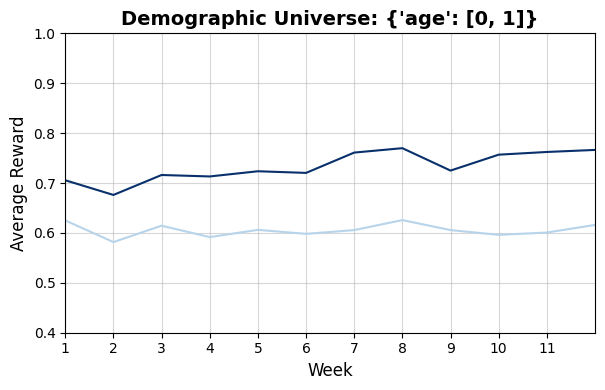

{'age': [0, 1, 2, 3]}
Recommendation Boost: 0.2
Recommendation Boost: 0.4


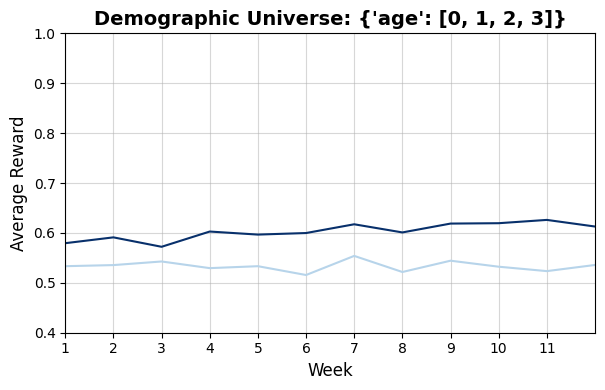

{'age': [0, 1, 2, 3, 4, 5]}
Recommendation Boost: 0.2
Recommendation Boost: 0.4


KeyboardInterrupt: 

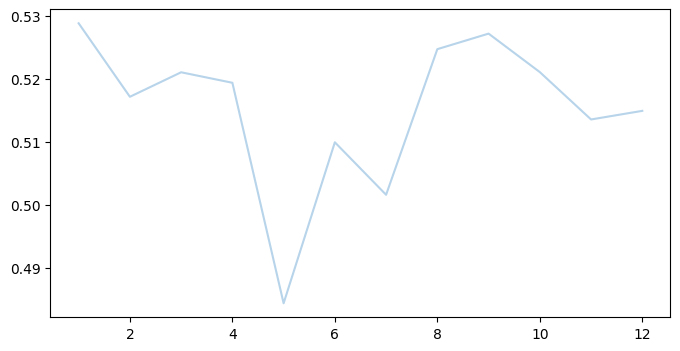

In [22]:
n_runs = 10
n_weeks = 12
n_users = 180
demographic_universe_list = [{"age": [0, 1]},
                             {"age": [0, 1, 2, 3]},
                             {"age": [0, 1, 2, 3, 4, 5]}]

pillars = ["Diet", "Physical Activity", "Smoking", "Alcohol", "Mental Wellbeing"]
n_missions_per_HHS = 3
top_recommendation_boost_list = [0.2, 0.4, 0.6, 0.8, 1.0]
print(f"Avg. times a Mission is explored with {n_users} users in {n_weeks} weeks: {n_users*n_weeks/len(pillars)/9/n_missions_per_HHS}\n")

for demographic_universe in demographic_universe_list:
    print(demographic_universe)
    run_expt1_multi(n_runs, n_weeks, n_users, demographic_universe, pillars, n_missions_per_HHS, top_recommendation_boost_list)

{'age': [0, 1]}
Recommendation Boost: 0.2
Recommendation Boost: 0.4
Recommendation Boost: 0.6
Recommendation Boost: 0.8
Recommendation Boost: 1.0


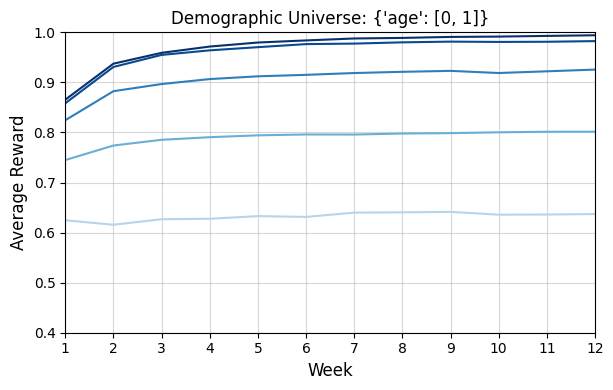

{'age': [0, 1, 2, 3]}
Recommendation Boost: 0.2
Recommendation Boost: 0.4
Recommendation Boost: 0.6
Recommendation Boost: 0.8
Recommendation Boost: 1.0


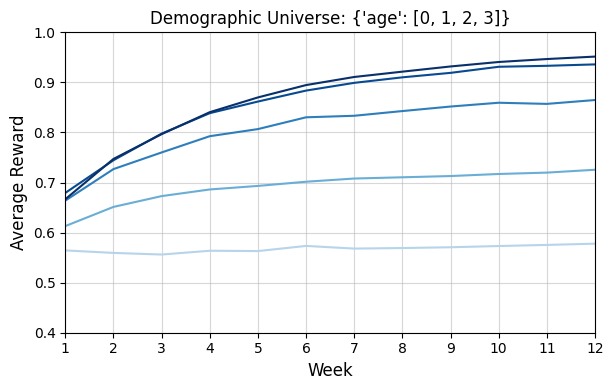

{'age': [0, 1, 2, 3, 4, 5]}
Recommendation Boost: 0.2
Recommendation Boost: 0.4
Recommendation Boost: 0.6
Recommendation Boost: 0.8
Recommendation Boost: 1.0


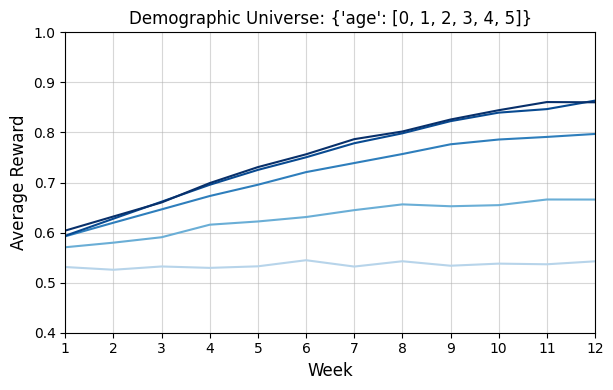

In [9]:
n_runs = 10
n_weeks = 12
n_users = 1800
demographic_universe_list = [{"age": [0, 1]},
                             {"age": [0, 1, 2, 3]},
                             {"age": [0, 1, 2, 3, 4, 5]}]

pillars = ["Diet", "Physical Activity", "Smoking", "Alcohol", "Mental Wellbeing"]
n_missions_per_HHS = 3
top_recommendation_boost_list = [0.2, 0.4, 0.6, 0.8, 1.0]
for demographic_universe in demographic_universe_list:
    print(demographic_universe)
    run_expt1_multi(n_runs, n_weeks, n_users, demographic_universe, pillars, n_missions_per_HHS, top_recommendation_boost_list)

LinAlgError: Singular matrix

/Users/andrespasinetti/Documents/Dottorato Polimi/ibechange-rl/ibechange_env/lib/python3.12/site-packages/matplotlib/_tight_bbox.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/Users/andrespasinetti/Documents/Dottorato Polimi/ibechange-rl/ibechange_env/lib/python3.12/site-packages/matplotlib/_tight_bbox.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  fig.bbox.width / w1, fig.bbox.height / h1)
/Users/andrespasinetti/Documents/Dottorato Polimi/ibechange-rl/ibechange_env/lib/python3.12/site-packages/matplotlib/patches.py:786: RuntimeWarning: invalid value encountered in scalar add
  x1 = self.convert_xunits(self._x0 + self._width)
/Users/andrespasinetti/Documents/Dottorato Polimi/ibechange-rl/ibechange_env/lib/python3.12/site-packages/matplotlib/patches.py:787: RuntimeWarning: invalid value encountered in scalar add
  y1 = self.convert_yunits(self._y0 + self._height)


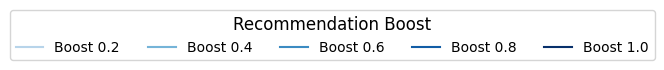

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# List of recommendation boosts
top_recommendation_boost_list = [0.2, 0.4, 0.6, 0.8, 1.0]

# Define a colormap and generate progressively darker shades
colormap = plt.cm.Blues  # You can use any colormap you like
colors = [colormap(0.3 + (i / (len(top_recommendation_boost_list) - 1)) * 0.7) for i in range(len(top_recommendation_boost_list))]

# Create a figure without any plot
plt.figure(figsize=(0, 0))  # Adjust figure size if necessary

# Create dummy plots for each recommendation boost to generate the legend with colors
for i, boost in enumerate(top_recommendation_boost_list):
    plt.plot([], [], label=f'Boost {boost}', color=colors[i])  # Invisible plot with color and label

# Add the legend with horizontal labels
plt.legend(
    title='Recommendation Boost', 
    fontsize=10, 
    title_fontsize=12, 
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.3),  # Adjust position if needed
    ncol=len(top_recommendation_boost_list)  # Ensure labels are side by side
)

# Remove axes and grid to ensure only the legend is shown
plt.axis('off')  # Hide the axes
plt.tight_layout()
plt.subplots_adjust(bottom=0.3)  # Adjust bottom margin to make room for the legend

# Show the legend only (no plot)
plt.show()
